In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

In [2]:
corDefault = "#6688AA"
corViridis = ['#440154', '#414487', '#2a788e', '#22a884', '#7ad151']

def set_plot_style():
    # Background colors
    plt.figure().patch.set_facecolor("0.85")
    plt.axes().set(facecolor="0.85")
    
    # Hiding grid
    plt.grid(False)
    
    # Setting only left and bottom spines as visible
    ax = plt.gca()
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Spines color
    ax.spines['bottom'].set_color("black")
    ax.spines['left'].set_color("black")
    
    # Plot size
    plt.gcf().set_size_inches(6, 5)

    # Plot Style
    plt.style.use('seaborn-v0_8-colorblind')

# **EXTRAÇÃO**

## **PESQUISA AGRÍCOLA MUNICIPAL (PAM)**

Código generalizado para exportar dados de um ano específico:
```Python
https://apisidra.ibge.gov.br/values/t/1612/n6/all/v/109,1000109/p/<ANO>/c81/2713/d/v1000109%205
```
Mudando o parâmetro `<ANO>` para o desejado, obtém-se os dados daquele período.

In [93]:
base_ibge = pd.read_json('https://apisidra.ibge.gov.br/values/t/1612/n6/all/v/109,1000109/p/2018,2019,2020,2021/c81/2713/d/v1000109%205')
base_ibge.columns = base_ibge.iloc[0]
base_ibge = base_ibge.iloc[1:].reset_index(drop = True)

In [94]:
base_ibge.head()

,Nível Territorial (Código),Nível Territorial,Unidade de Medida (Código),Unidade de Medida,Valor,Município (Código),Município,Variável (Código),Variável,Ano (Código),Ano,Produto das lavouras temporárias (Código),Produto das lavouras temporárias
0,6,Município,1006,Hectares,450,1100015,Alta Floresta D'Oeste - RO,109,Área plantada,2018,2018,2713,Soja (em grão)
1,6,Município,1006,Hectares,450,1100015,Alta Floresta D'Oeste - RO,109,Área plantada,2019,2019,2713,Soja (em grão)
2,6,Município,1006,Hectares,450,1100015,Alta Floresta D'Oeste - RO,109,Área plantada,2020,2020,2713,Soja (em grão)
3,6,Município,1006,Hectares,1072,1100015,Alta Floresta D'Oeste - RO,109,Área plantada,2021,2021,2713,Soja (em grão)
4,6,Município,2,Percentual,3.94460,1100015,Alta Floresta D'Oeste - RO,1000109,Área plantada - percentual do total geral,2018,2018,2713,Soja (em grão)


In [95]:
base_ibge = base_ibge[['Município (Código)', 'Município', 'Ano', 'Variável', 'Valor']]
base_ibge.columns = ['cod_municipio', 'municipio', 'ano', 'variavel', 'valor']

cidades = base_ibge[['cod_municipio', 'municipio']].copy().drop_duplicates('cod_municipio').reset_index(drop = True)
cidades['uf'] = cidades['municipio'].apply(lambda x: x[-2:])
cidades['municipio'] = cidades['municipio'].apply(lambda x: x[:-5])

base_ibge = base_ibge.pivot(
    index = ['cod_municipio', 'ano'],
    columns = 'variavel',
    values = 'valor'
).reset_index()
base_ibge.columns.name = None
base_ibge.columns = ['cod_municipio', 'ano', 'area_plantada', 'pct_area']
base_ibge['ano'] = base_ibge['ano'].astype(int)

base_ibge['area_plantada'] = base_ibge['area_plantada'].apply(lambda x: 0 if x == "-" else x)
base_ibge['area_plantada'] = base_ibge['area_plantada'].apply(lambda x: 0 if x == "..." else x)
base_ibge['pct_area'] = base_ibge['pct_area'].apply(lambda x: 0 if x == "-" else x)
base_ibge['pct_area'] = base_ibge['pct_area'].apply(lambda x: 0 if x == "..." else x)

base_ibge['area_plantada'] = base_ibge['area_plantada'].astype(float)
base_ibge['pct_area'] = base_ibge['pct_area'].astype(float)

base_ibge = base_ibge.merge(cidades, on = 'cod_municipio', how = 'left')

base_ibge.head(7)

,cod_municipio,ano,area_plantada,pct_area,municipio,uf
0,1100015,2018,450.0,3.94460,Alta Floresta D'Oeste,RO
1,1100015,2019,450.0,3.94391,Alta Floresta D'Oeste,RO
2,1100015,2020,450.0,3.93977,Alta Floresta D'Oeste,RO
3,1100015,2021,1072.0,6.81890,Alta Floresta D'Oeste,RO
4,1100023,2018,5600.0,72.78399,Ariquemes,RO
5,1100023,2019,7893.0,76.30510,Ariquemes,RO
6,1100023,2020,7782.0,76.85167,Ariquemes,RO


## **ESTIMATIVA DE SAFRA**

In [6]:
base_conab = pd.read_table('https://portaldeinformacoes.conab.gov.br/downloads/arquivos/SerieHistoricaGraos.txt', encoding = 'latin1', sep = ';')
base_conab.head()

,ano_agricola,dsc_safra_previsao,uf,produto,id_produto,area_plantada_mil_ha,producao_mil_t,produtividade_mil_ha_mil_t
0,1976/77,UNICA,AL,ALGODAO EM PLUMA,4586,99.3,6.0,0.1
1,1976/77,UNICA,BA,ALGODAO EM PLUMA,4586,123.4,7.0,0.1
2,1976/77,UNICA,CE,ALGODAO EM PLUMA,4586,1296.0,70.0,0.1
3,1976/77,UNICA,GO,ALGODAO EM PLUMA,4586,73.1,28.2,0.4
4,1976/77,UNICA,MA,ALGODAO EM PLUMA,4586,44.4,2.0,0.0


In [7]:
colunas_str = base_conab.select_dtypes(include = 'object').columns.tolist()
base_conab[colunas_str] = base_conab[colunas_str].apply(lambda s: s.str.strip())

base_conab = base_conab[base_conab['produto'] == "SOJA"].copy().reset_index(drop = True)

safras_consideradas = ['2017/18', '2018/19', '2019/20', '2020/21', '2021/22']
mask = base_conab['ano_agricola'].isin(safras_consideradas)
base_conab = base_conab[mask].reset_index(drop = True)

base_conab['ano'] = base_conab['ano_agricola'].apply(lambda x: x[-2:]).astype(int)
base_conab['ano'] += 2000

base_conab = base_conab[['ano', 'ano_agricola', 'uf', 'area_plantada_mil_ha']]
base_conab.columns = ['ano', 'safra', 'uf', 'area_plantada']
base_conab['area_plantada'] = base_conab['area_plantada'] * 1000
base_conab = base_conab.sort_values(['ano', 'uf'])

base_conab.head()

,ano,safra,uf,area_plantada
0,2018,2017/18,AC,1000.0
1,2018,2017/18,AL,2000.0
2,2018,2017/18,AM,2000.0
3,2018,2017/18,AP,20000.0
4,2018,2017/18,BA,1599000.0


# **DATASETS PREPROCESSADOS**

In [29]:
base_ibge_backup = base_ibge.copy()
base_ibge[['cod_municipio', 'ano', 'area_plantada']].to_feather('../dados/processados/base_ibge.feather')
base_ibge.head()

,cod_municipio,ano,area_plantada,pct_area,municipio,uf
0,1100015,2018,450.0,3.94460,Alta Floresta D'Oeste,RO
1,1100015,2019,450.0,3.94391,Alta Floresta D'Oeste,RO
2,1100015,2020,450.0,3.93977,Alta Floresta D'Oeste,RO
3,1100015,2021,1072.0,6.81890,Alta Floresta D'Oeste,RO
4,1100023,2018,5600.0,72.78399,Ariquemes,RO


In [30]:
base_conab_backup = base_conab.copy()
base_conab.to_feather('../dados/processados/base_conab.feather')
base_conab.head()

,ano,safra,uf,area_plantada
0,2018,2017/18,AC,1000.0
1,2018,2017/18,AL,2000.0
2,2018,2017/18,AM,2000.0
3,2018,2017/18,AP,20000.0
4,2018,2017/18,BA,1599000.0


# **ANÁLISES**

## Análise comparativa a nível nacional das áreas plantadas de soja apontadas pelo IBGE e pela CONAB para os anos de apontadas pelo IBGE e pela CONAB para os anos de 2019 (18/19), 2020 (19/20) e 2021 (20/21)

In [12]:
df_nacional = (
    base_ibge[(base_ibge['ano'] > 2018) & (base_ibge['ano'] < 2022)].groupby('ano')['area_plantada'].agg(
        area_plantada_ibge = 'sum'
    )
)

df_nacional = pd.concat([
    df_nacional,
    base_conab[(base_conab['ano'] > 2018) & (base_conab['ano'] < 2022)].groupby('ano')['area_plantada'].agg(
        area_plantada_conab = 'sum'
    )
], axis = 1)

df_nacional = df_nacional.reset_index()

df_nacional['variacao_conab_ibge'] = (df_nacional['area_plantada_conab'] / df_nacional['area_plantada_ibge']) - 1
df_nacional['ano'] = df_nacional['ano'].astype(int)
df_nacional

,ano,area_plantada_ibge,area_plantada_conab,variacao_conab_ibge
0,2019,35944094.0,35876000.0,-0.001894
1,2020,37204962.0,36948000.0,-0.006907
2,2021,39143946.0,39531200.0,0.009893


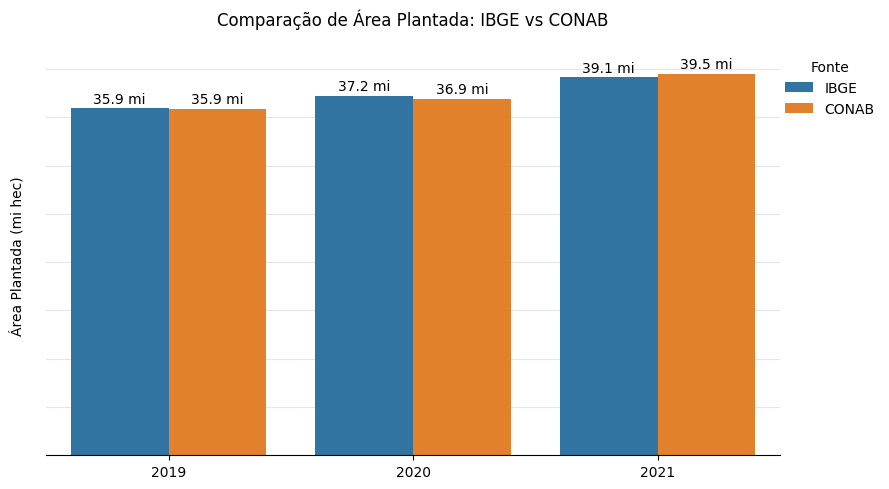

In [13]:
df_nacional_long_graf = df_nacional.melt(
    id_vars = ['ano'],
    value_vars = ['area_plantada_ibge', 'area_plantada_conab'],
    var_name = 'fonte',
    value_name = 'area_plantada'
)

df_nacional_long_graf['fonte'] = np.where(
    df_nacional_long_graf['fonte'] == "area_plantada_ibge",
    "IBGE",
    "CONAB"
)

df_nacional_long_graf['area_plantada'] = df_nacional_long_graf['area_plantada'] / 1000000

fig, ax = plt.subplots(figsize = (9, 5))
ax.grid(axis = 'y', color = '0.90', linewidth = .8, zorder = 0)
ax.set_axisbelow(True)
sns.barplot(data = df_nacional_long_graf, x = 'ano', y = 'area_plantada', hue = 'fonte', ax = ax)
ax.set_title('Comparação de Área Plantada: IBGE vs CONAB\n')
ax.set_xlabel('')
ax.set_ylabel('Área Plantada (mi hec)\n')

for container in ax.containers:
    ax.bar_label(container, fmt = '%.1f mi', padding = 2)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.left.set_visible(False)
ax.tick_params(axis='y', which='both', length=0, labelleft=False)
ax.set_yticklabels([])

ax.legend(
    title = 'Fonte',
    bbox_to_anchor = (1, 1),
    loc = 'upper left',
    borderaxespad = 0,
    frameon = False
)

plt.tight_layout()
plt.show()
plt.close()

In [14]:
df_nacional_long = df_nacional.melt(
    id_vars = ['ano'],
    value_vars = ['area_plantada_ibge', 'area_plantada_conab', 'variacao_conab_ibge'],
    var_name = 'fonte',
    value_name = 'valor'
)

df_nacional_long['fonte'] = np.where(
    df_nacional_long['fonte'] == "area_plantada_ibge",
    "IBGE",
    np.where(
        df_nacional_long['fonte'] == "area_plantada_conab",
        "CONAB",
        "VARIAÇÃO CONAB X IBGE"
    )
)
df_nacional_long

,ano,fonte,valor
0,2019,IBGE,3.594409e+07
1,2020,IBGE,3.720496e+07
2,2021,IBGE,3.914395e+07
3,2019,CONAB,3.587600e+07
4,2020,CONAB,3.694800e+07
5,2021,CONAB,3.953120e+07
6,2019,VARIAÇÃO CONAB X IBGE,-1.894442e-03
7,2020,VARIAÇÃO CONAB X IBGE,-6.906659e-03
8,2021,VARIAÇÃO CONAB X IBGE,9.893075e-03


In [329]:
df_nacional_long.to_feather('../dados/processados/df_nacional.feather')

## Análise comparativa a nível estadual das áreas plantadas de soja apontadas pelo IBGE e pela CONAB para os anos de apontadas pelo IBGE e pela CONAB para os anos de 2019 (18/19), 2020 (19/20) e 2021 (20/21)

In [31]:
df_estadual = (
    base_ibge[(base_ibge['ano'] > 2018) & (base_ibge['ano'] < 2022)].groupby(['uf', 'ano'])['area_plantada'].agg(
        area_plantada_ibge = 'sum'
    )
)

df_estadual = pd.concat(
    [
        df_estadual,
        base_conab[(base_conab['ano'] > 2018) & (base_conab['ano'] < 2022)].groupby(['uf', 'ano'])['area_plantada'].agg(
            area_plantada_conab = 'sum'
        )
    ],
    axis = 1
)

df_estadual['variacao_conab_ibge'] = (df_estadual['area_plantada_conab'] / df_estadual['area_plantada_ibge']) - 1
df_estadual = df_estadual.reset_index()

df_estadual

,uf,ano,area_plantada_ibge,area_plantada_conab,variacao_conab_ibge
0,AC,2019,1660.0,2000.0,0.204819
1,AC,2020,3280.0,4000.0,0.219512
2,AC,2021,6185.0,6100.0,-0.013743
3,AL,2019,3141.0,2000.0,-0.363260
4,AL,2020,1224.0,1000.0,-0.183007
...,...,...,...,...,...
76,SP,2020,1132965.0,1110000.0,-0.020270
77,SP,2021,1199351.0,1162000.0,-0.031143
78,TO,2019,905281.0,1029000.0,0.136664
79,TO,2020,962399.0,1078000.0,0.120118


In [32]:
df_comp = df_estadual[df_estadual['ano'] == 2020].copy().sort_values('uf').reset_index(drop = True)
df_comp = df_comp.drop(columns = {'ano', 'variacao_conab_ibge'}, axis = 1)
df_comp = df_comp.rename(columns = {'area_plantada_ibge': 'area_plantada_ibge_2020', 'area_plantada_conab': 'area_plantada_conab_2020'})
df_comp = pd.concat(
    [
        df_comp,
        df_estadual[df_estadual['ano'] == 2021].sort_values('uf')[['area_plantada_ibge', 'area_plantada_conab']].reset_index(drop = True)
    ],
    axis = 1
)
df_comp = df_comp.rename(columns = {'area_plantada_ibge': 'area_plantada_ibge_2021', 'area_plantada_conab': 'area_plantada_conab_2021'})

df_comp['variacao_ibge'] = df_comp['area_plantada_ibge_2021'] - df_comp['area_plantada_ibge_2020']
df_comp['variacao_conab'] = df_comp['area_plantada_conab_2021'] - df_comp['area_plantada_conab_2020']

df_comp

,uf,area_plantada_ibge_2020,area_plantada_conab_2020,area_plantada_ibge_2021,area_plantada_conab_2021,variacao_ibge,variacao_conab
0,AC,3280.0,4000.0,6185.0,6100.0,2905.0,2100.0
1,AL,1224.0,1000.0,3312.0,2800.0,2088.0,1800.0
2,AM,2700.0,2000.0,3000.0,4300.0,300.0,2300.0
3,AP,20300.0,21000.0,6715.0,5300.0,-13585.0,-15700.0
4,BA,1622475.0,1620000.0,1699965.0,1701000.0,77490.0,81000.0
5,CE,450.0,0.0,1414.0,0.0,964.0,0.0
6,DF,74500.0,74000.0,80000.0,78500.0,5500.0,4500.0
7,ES,0.0,0.0,0.0,0.0,0.0,0.0
8,GO,3577700.0,3545000.0,3857007.0,4299000.0,279307.0,754000.0
9,MA,960900.0,976000.0,1023541.0,1005700.0,62641.0,29700.0


In [483]:
df_comp_conab = pd.DataFrame([{
    'step': 'START',
    'valor': df_comp['area_plantada_ibge_2020'].sum()
}])

df_comp_conab = pd.concat(
    [
        df_comp_conab,
        df_comp[['uf', 'variacao_ibge']].rename(columns = {'uf': 'step', 'variacao_ibge': 'valor'})
    ],
    axis = 0,
    ignore_index = True
)


df_comp_conab = df_comp_conab[df_comp_conab['valor'].abs() > 0].reset_index(drop = True)

ddf = pd.DataFrame([{
    'step': 'END',
    'valor': df_comp_conab['valor'].sum()
}])

df_comp_conab = pd.concat([df_comp_conab, ddf], axis = 0, ignore_index = True)
df_comp_conab['measure'] = np.where(
    (df_comp_conab['step'] == "START"),
    "absolute",
    np.where(
        (df_comp_conab['step'] == "END"),
        "total",
        "relative"
    )
)


df_comp_conab['step'] = np.where(
    (df_comp_conab['step'] == "START"),
    "2020",
    np.where(
        (df_comp_conab['step'] == "END"),
        "2021",
        df_comp_conab['step']
    )
)

df_comp_conab.to_feather('../dados/processados/df_waterfall_ibge_2020_2021.feather')

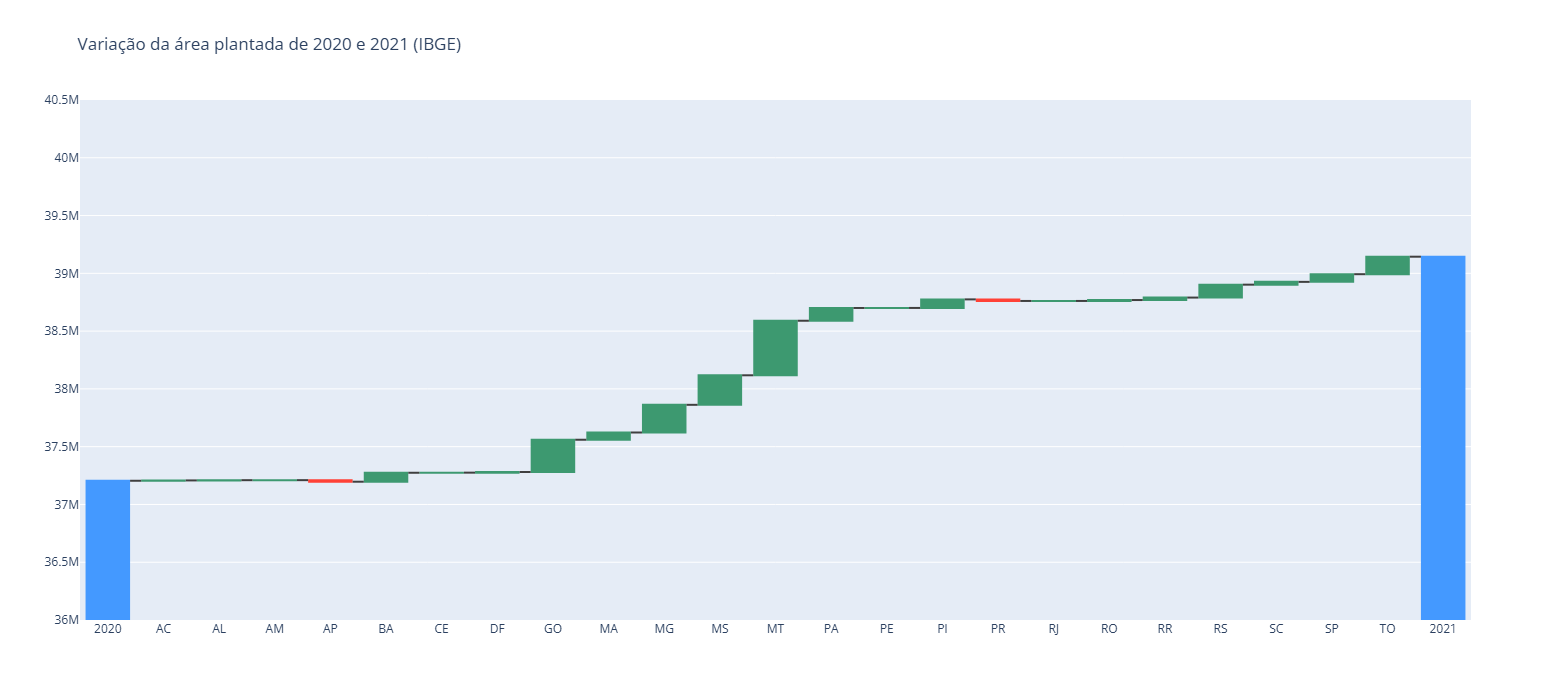

In [484]:
import plotly.graph_objects as go

fig = go.Figure(go.Waterfall(
    orientation = "v",
    x = df_comp_conab['step'],
    y = df_comp_conab['valor'],
    measure = df_comp_conab['measure'],
    connector = {"line":{"color":"rgb(63, 63, 63)"}},
))

fig.update_layout(
        title = "Variação da área plantada de 2020 e 2021 (IBGE)",
        showlegend = False,
        height = 700,
        yaxis = dict(
            range = [36000000, 40500000]
        )
)

fig.show()

In [216]:
df_comp = df_estadual[df_estadual['ano'] == 2021].copy().sort_values('uf').reset_index(drop = True)
df_comp = df_comp.drop(columns = {'ano', 'variacao_conab_ibge', 'area_plantada_ibge'}, axis = 1)
df_comp = df_comp.rename(columns = {'area_plantada_conab': 'area_plantada_conab_2021'})
df_comp = pd.concat(
    [
        df_comp,
        base_conab[base_conab['ano'] == 2022].sort_values('uf')[['area_plantada']].reset_index(drop = True)
    ],
    axis = 1
)
df_comp = df_comp.rename(columns = {'area_plantada': 'area_plantada_conab_2022'})

df_comp['variacao_conab'] = df_comp['area_plantada_conab_2022'] - df_comp['area_plantada_conab_2021']

df_comp.head()

,uf,area_plantada_conab_2021,area_plantada_conab_2022,variacao_conab
0,AC,6100.0,6100.0,0.0
1,AL,2800.0,2300.0,-500.0
2,AM,4300.0,4500.0,200.0
3,AP,5300.0,6500.0,1200.0
4,BA,1701000.0,1893200.0,192200.0


In [220]:
df_comp_conab = pd.DataFrame([{
    'step': 'START',
    'valor': df_comp['area_plantada_conab_2021'].sum()
}])

df_comp_conab = pd.concat(
    [
        df_comp_conab,
        df_comp[['uf', 'variacao_conab']].rename(columns = {'uf': 'step', 'variacao_conab': 'valor'})
    ],
    axis = 0,
    ignore_index = True
)


df_comp_conab = df_comp_conab[df_comp_conab['valor'].abs() > 0].reset_index(drop = True)

ddf = pd.DataFrame([{
    'step': 'END',
    'valor': df_comp_conab['valor'].sum()
}])

df_comp_conab = pd.concat([df_comp_conab, ddf], axis = 0, ignore_index = True)
df_comp_conab['measure'] = np.where(
    (df_comp_conab['step'] == "START"),
    "absolute",
    np.where(
        (df_comp_conab['step'] == "END"),
        "total",
        "relative"
    )
)


df_comp_conab['step'] = np.where(
    (df_comp_conab['step'] == "START"),
    "2021",
    np.where(
        (df_comp_conab['step'] == "END"),
        "2022",
        df_comp_conab['step']
    )
)

df_comp_conab.to_feather('../dados/processados/df_waterfall_conab_2021_2022.feather')

In [371]:
df_comp_conab.head()

,step,valor,measure
0,2021,39531200.0,absolute
1,AL,-500.0,relative
2,AM,200.0,relative
3,AP,1200.0,relative
4,BA,192200.0,relative


In [33]:
df_estadual_long = df_estadual.melt(
    id_vars = ['uf', 'ano'],
    value_vars = ['area_plantada_ibge', 'area_plantada_conab', 'variacao_conab_ibge'],
    var_name = 'fonte',
    value_name = 'valor'
)

df_estadual_long['fonte'] = np.where(
    df_estadual_long['fonte'] == "area_plantada_ibge",
    "IBGE",
    np.where(
        df_estadual_long['fonte'] == "area_plantada_conab",
        "CONAB",
        "VARIAÇÃO CONAB X IBGE"
    )
)

df_estadual_long

,uf,ano,fonte,valor
0,AC,2019,IBGE,1660.000000
1,AC,2020,IBGE,3280.000000
2,AC,2021,IBGE,6185.000000
3,AL,2019,IBGE,3141.000000
4,AL,2020,IBGE,1224.000000
...,...,...,...,...
238,SP,2020,VARIAÇÃO CONAB X IBGE,-0.020270
239,SP,2021,VARIAÇÃO CONAB X IBGE,-0.031143
240,TO,2019,VARIAÇÃO CONAB X IBGE,0.136664
241,TO,2020,VARIAÇÃO CONAB X IBGE,0.120118


In [331]:
df_estadual_long.to_feather('../dados/processados/df_estadual.feather')

## Área plantada por município em 2022

In [333]:
df_2022 = base_ibge[base_ibge['ano'] == 2021].copy().reset_index(drop = True)
df_2022['total_por_uf'] = df_2022.groupby('uf')['area_plantada'].transform('sum')
df_2022['repres_mun'] = df_2022['area_plantada'] / df_2022['total_por_uf']
df_2022 = df_2022[['cod_municipio', 'uf', 'repres_mun']]
df_2022 = df_2022.merge(base_conab[base_conab['ano'] == 2022][['uf', 'area_plantada']], on = 'uf', how = 'left')
df_2022['area_plantada_2022'] = df_2022['repres_mun'] * df_2022['area_plantada']
df_2022 = df_2022.drop('area_plantada', axis = 1)
df_2022 = df_2022[['cod_municipio', 'area_plantada_2022']]
df_2022

,cod_municipio,area_plantada_2022
0,1100015,1316.245608
1,1100023,8569.102705
2,1100031,34017.336357
3,1100049,2652.136673
4,1100056,44730.249539
...,...,...
5558,5222005,46703.985759
5559,5222054,27908.479295
5560,5222203,2050.418887
5561,5222302,26142.840809


In [334]:
df_2022.to_feather('../dados/processados/df_2022.feather')

## Município 5100201

In [366]:
mun_5100201 = df_2022[['cod_municipio', 'area_plantada_2022']].copy().rename(columns = {'area_plantada_2022': 'area_plantada'})
mun_5100201['ano'] = 2022

mun_5100201 = pd.concat(
    [
        base_ibge[['cod_municipio', 'area_plantada', 'ano']],
        mun_5100201
    ],
    axis = 0,
    ignore_index = True
)

base_municipios = mun_5100201.copy()

mun_5100201 = mun_5100201[mun_5100201['cod_municipio'] == "5100201"].copy().reset_index(drop = True)
mun_5100201['area_plantada'] = np.round(mun_5100201['area_plantada'], 0)
mun_5100201['area_plantada'] = mun_5100201['area_plantada'].astype(int)

mun_5100201 = mun_5100201.merge(cidades, on = 'cod_municipio', how = 'left')
mun_5100201 = mun_5100201[['ano', 'cod_municipio', 'municipio', 'area_plantada']]
mun_5100201

,ano,cod_municipio,municipio,area_plantada
0,2018,5100201,Água Boa,160000
1,2019,5100201,Água Boa,160000
2,2020,5100201,Água Boa,178000
3,2021,5100201,Água Boa,175000
4,2022,5100201,Água Boa,185819


In [157]:
mun_5100201.to_feather('../dados/processados/mun_5100201.feather')

In [262]:
siglas = ['AC', 'AL', 'AP', 'AM', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MT', 'MS', 'MG', 'PA', 'PB', 'PR', 'PE', 'PI', 'RJ', 'RN', 'RS', 'RO', 'RR', 'SC', 'SP', 'SE', 'TO']
estados = ['Acre', 'Alagoas', 'Amapá', 'Amazonas', 'Bahia', 'Ceará', 'Distrito Federal', 'Espírito Santo', 'Goiás',
        'Maranhão', 'Mato Grosso', 'Mato Grosso do Sul', 'Minas Gerais', 'Pará', 'Paraíba', 'Paraná', 'Pernambuco', 'Piauí', 'Rio de Janeiro',
        'Rio Grande do Norte', 'Rio Grande do Sul', 'Rondônia', 'Roraima', 'Santa Catarina', 'São Paulo', 'Sergipe', 'Tocantins']

ddd = pd.DataFrame(siglas, columns = ['uf'])
dddd = pd.DataFrame(estados, columns = ['estado'])

ddd = pd.concat([ddd, dddd], axis = 1)

In [367]:
base_municipios = base_municipios.sort_values(['cod_municipio', 'ano']).reset_index(drop = True)
base_municipios = base_municipios.merge(cidades, on = 'cod_municipio', how = 'left')
base_municipios['key'] = base_municipios['uf'] + "-" + base_municipios['ano'].astype(str)

dd = base_conab[base_conab['ano'] == 2022]
dd = dd.groupby('uf')['area_plantada'].agg(
    area_plantada_estado_ibge = 'sum'
).reset_index()
dd['ano'] = 2022

d = base_ibge.groupby(['uf', 'ano'])['area_plantada'].agg(
    area_plantada_estado_ibge = 'sum'
).reset_index()
d = pd.concat([d, dd], ignore_index = True, axis = 0)

text_safra = ((base_municipios['ano'] - 2) - 2000).astype(str) + "/" + ((base_municipios['ano'] - 1) - 2000).astype(str)
text_safra_d = ((d['ano'] - 2) - 2000).astype(str) + "/" + ((d['ano'] - 1) - 2000).astype(str)

d['variacao_estado_ano'] = d.groupby('uf')['area_plantada_estado_ibge'].shift(1)
d['variacao_estado_ano'] = np.round((d['area_plantada_estado_ibge'] / d['variacao_estado_ano'] - 1) * 100, 1)
d['variacao_estado_ano'] = np.where(
    d['variacao_estado_ano'].isna(),
    np.nan,
    np.where(
        d['variacao_estado_ano'] > 0,
        "+" + d['variacao_estado_ano'].astype(str).str.replace(".", ",") + "% vs " + text_safra_d,
        np.where(
            d['variacao_estado_ano'] < 0,
            d['variacao_estado_ano'].astype(str).str.replace(".", ",") + "% vs " + text_safra_d,
            "0% vs " + text_safra_d
        )
    )
)

d['key'] = d['uf'] + "-" + d['ano'].astype(str)

base_municipios = base_municipios.merge(d[['key', 'area_plantada_estado_ibge', 'variacao_estado_ano']], on = 'key', how = 'left')
base_municipios['representatividade_mun'] = np.round((base_municipios['area_plantada'] / base_municipios['area_plantada_estado_ibge']) * 100, 2)
base_municipios['representatividade_mun'] = np.where(
    base_municipios['representatividade_mun'].isna(),
    np.nan,
    base_municipios['representatividade_mun'].astype(str).str.replace(".", ",") + "%"
)

base_municipios['variacao'] = np.round((base_municipios['area_plantada'] / base_municipios['area_plantada'].shift(1) - 1) * 100, 1)
base_municipios['variacao'] = np.where(
    base_municipios['variacao'].isna(),
    np.nan,
    np.where(
        base_municipios['variacao'] > 0,
        "+" + base_municipios['variacao'].astype(str).str.replace(".", ",") + "% vs " + text_safra,
        np.where(
            base_municipios['variacao'] < 0,
            base_municipios['variacao'].astype(str).str.replace(".", ",") + "% vs " + text_safra,
            "0% vs " + text_safra
        )
    )
)
base_municipios = base_municipios[base_municipios['ano'] > 2018].reset_index(drop = True)
base_municipios = base_municipios.drop('key', axis = 1)
base_municipios['area_plantada_estado_dif'] = np.round((base_municipios['area_plantada_estado_ibge'] - base_municipios['area_plantada']) / 1000, 1)
base_municipios['area_plantada_estado_ibge'] = np.round(base_municipios['area_plantada_estado_ibge'] / 1000, 1)

df_ranking = base_municipios[base_municipios['area_plantada'].notna()].copy()
df_ranking = df_ranking[df_ranking['area_plantada'] > 0]
df_ranking['ranking'] = df_ranking.groupby(['uf', 'ano'])['area_plantada'].rank(method='min',ascending=False)
df_ranking = df_ranking.sort_values(['uf', 'ano', 'ranking']).reset_index(drop = True)
df_ranking['ranking'] = df_ranking['ranking'].astype(int)
df_ranking['key'] = df_ranking['cod_municipio'] + "-" + df_ranking['ano'].astype(str)
df_ranking = df_ranking[['key', 'ranking']]

base_municipios['key'] = base_municipios['cod_municipio'] + "-" + base_municipios['ano'].astype(str)
base_municipios = base_municipios.merge(df_ranking, on = 'key', how = 'left')
base_municipios = base_municipios.drop('key', axis = 1)
base_municipios['ranking'] = base_municipios['ranking'].astype('Int64')
base_municipios['ranking'] = np.where(
    base_municipios['ranking'].isna(),
    np.nan,
    base_municipios['ranking'].astype(str) + "º no estado"
)

base_municipios['area_plantada'] = np.round(base_municipios['area_plantada'] / 1000, 1)
base_municipios = base_municipios.rename(columns = {'area_plantada_estado_ibge': 'area_plantada_estado'})
base_municipios = base_municipios.merge(ddd, on = 'uf', how = 'left')
base_municipios['ano_safra'] = ((base_municipios['ano'] - 1) - 2000).astype(str) + "/" + ((base_municipios['ano']) - 2000).astype(str)
base_municipios

,cod_municipio,area_plantada,ano,municipio,uf,area_plantada_estado,variacao_estado_ano,representatividade_mun,variacao,area_plantada_estado_dif,ranking,estado,ano_safra
0,1100015,0.4,2019,Alta Floresta D'Oeste,RO,344.6,"+14,5% vs 17/18","0,13%",0% vs 17/18,344.1,28º no estado,Rondônia,18/19
1,1100015,0.4,2020,Alta Floresta D'Oeste,RO,392.6,"+14,0% vs 18/19","0,11%",0% vs 18/19,392.2,30º no estado,Rondônia,19/20
2,1100015,1.1,2021,Alta Floresta D'Oeste,RO,400.5,"+2,0% vs 19/20","0,27%","+138,2% vs 19/20",399.4,30º no estado,Rondônia,20/21
3,1100015,1.3,2022,Alta Floresta D'Oeste,RO,491.7,"+22,8% vs 20/21","0,27%","+22,8% vs 20/21",490.4,30º no estado,Rondônia,21/22
4,1100023,7.9,2019,Ariquemes,RO,344.6,"+14,5% vs 17/18","2,29%","+40,9% vs 17/18",336.7,13º no estado,Rondônia,18/19
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22247,5222302,26.1,2022,Vila Propício,GO,4393.6,"+13,9% vs 20/21","0,6%","+13,9% vs 20/21",4367.5,45º no estado,Goiás,21/22
22248,5300108,75.0,2019,Brasília,DF,75.0,"+4,9% vs 17/18","100,0%","+4,9% vs 17/18",0.0,1º no estado,Distrito Federal,18/19
22249,5300108,74.5,2020,Brasília,DF,74.5,"-0,7% vs 18/19","100,0%","-0,7% vs 18/19",0.0,1º no estado,Distrito Federal,19/20
22250,5300108,80.0,2021,Brasília,DF,80.0,"+7,4% vs 19/20","100,0%","+7,4% vs 19/20",0.0,1º no estado,Distrito Federal,20/21


In [368]:
base_municipios.to_feather('../dados/processados/base_municipios.feather')

In [390]:
base_municipios[base_municipios['cod_municipio'] == '5100201']

,cod_municipio,area_plantada,ano,municipio,uf,area_plantada_estado,variacao_estado_ano,representatividade_mun,variacao,area_plantada_estado_dif,ranking,estado,ano_safra
20704,5100201,160.0,2019,Água Boa,MT,9724.2,"+3,0% vs 17/18","1,65%",0% vs 17/18,9564.2,22º no estado,Mato Grosso,18/19
20705,5100201,178.0,2020,Água Boa,MT,9989.6,"+2,7% vs 18/19","1,78%","+11,3% vs 18/19",9811.6,22º no estado,Mato Grosso,19/20
20706,5100201,175.0,2021,Água Boa,MT,10461.7,"+4,7% vs 19/20","1,67%","-1,7% vs 19/20",10286.7,24º no estado,Mato Grosso,20/21
20707,5100201,185.8,2022,Água Boa,MT,11108.5,"+6,2% vs 20/21","1,67%","+6,2% vs 20/21",10922.7,24º no estado,Mato Grosso,21/22


# **INDICADORES**

## **ÁREA NACIONAL**

In [354]:
area_nacional = base_ibge.groupby('ano')['area_plantada'].sum().reset_index().rename(columns = {'area_plantada': 'area_plantada_ibge'})
area_nacional = pd.concat(
    [
        area_nacional,
        pd.DataFrame([{
            'ano': 2022,
            'area_plantada_ibge': np.nan
        }])
    ]
)
area_nacional['variacao_ibge'] = (area_nacional['area_plantada_ibge'] / area_nacional['area_plantada_ibge'].shift(1)) - 1

area_nacional['media_ibge'] = area_nacional['variacao_ibge'].mean()
area_nacional['comp_ibge'] = np.where(
    area_nacional['variacao_ibge'] > area_nacional['media_ibge'],
    "Acima da média histórica",
    "Abaixo da média histórica"
)

area_nacional = area_nacional.set_index('ano')
area_nacional = pd.concat(
    [
        area_nacional,
        base_conab.groupby('ano')[['area_plantada']].sum().rename(columns = {'area_plantada': 'area_plantada_conab'})
    ], axis = 1
).reset_index()
area_nacional['variacao_conab'] = (area_nacional['area_plantada_conab'] / area_nacional['area_plantada_conab'].shift(1)) - 1

area_nacional['media_conab'] = area_nacional['variacao_conab'].mean()
area_nacional['comp_conab'] = np.where(
    area_nacional['variacao_conab'] > area_nacional['media_conab'],
    "Acima da média histórica",
    "Abaixo da média histórica"
)

area_nacional = area_nacional.set_index('ano')
d = base_ibge[base_ibge['area_plantada'] > 0].groupby('ano')['cod_municipio'].agg(
    qtde_mun = 'count'
)
d['var_mun'] = np.round((d['qtde_mun'] / d['qtde_mun'].shift(1) - 1) * 100, 2)
area_nacional = pd.concat([area_nacional, d], axis = 1).reset_index()
area_nacional['qtde_mun'] = area_nacional['qtde_mun'].astype('Int64')

area_nacional['var_mun_text'] = np.where(
    area_nacional['var_mun'].isna(),
    "Sem dados para comparação",
    np.where(
        area_nacional['var_mun'] < 0,
        "Diminuição de " + area_nacional['var_mun'].astype(str).str.replace(".", ",") + "%",
        "Aumento de " + area_nacional['var_mun'].astype(str).str.replace(".", ",") + "%"
    )    
)

area_nacional = area_nacional.drop(columns = {'media_ibge', 'media_conab', 'var_mun'}, axis = 1)
area_nacional = area_nacional[area_nacional['ano'] > 2018].reset_index(drop = True)

text_safra_atual = ((area_nacional['ano'] - 1) - 2000).astype(str) + "/" + ((area_nacional['ano']) - 2000).astype(str)
area_nacional['ano_safra'] = ((area_nacional['ano'] - 1) - 2000).astype(str) + "/" + ((area_nacional['ano']) - 2000).astype(str)

area_nacional['gap_ibge_conab'] = np.round(((area_nacional['area_plantada_ibge'] / area_nacional['area_plantada_conab']) - 1) * 100, 2)
area_nacional['gap_ibge_conab_text'] = np.where(
    area_nacional['gap_ibge_conab'].isna(),
    "Sem dados para comparação",
    np.where(
        area_nacional['gap_ibge_conab'] < 0,
        "CONAB superior em " + text_safra_atual,
        "IBGE superior em " + text_safra_atual
    )
)

area_nacional['area_plantada_ibge'] = np.round(area_nacional['area_plantada_ibge'] / 1000000, 1)
area_nacional['area_plantada_conab'] = np.round(area_nacional['area_plantada_conab'] / 1000000, 1)

area_nacional['variacao_ibge'] = np.round((area_nacional['variacao_ibge'] * 100), 1)
area_nacional['variacao_conab'] = np.round((area_nacional['variacao_conab'] * 100), 1)

area_nacional['gap_ibge_conab'] = np.where(
    area_nacional['gap_ibge_conab'].isna(),
    np.nan,
    "+" + area_nacional['gap_ibge_conab'].abs().astype(str).str.replace(".", ",") + "%"
)

text_safra = ((area_nacional['ano'] - 2) - 2000).astype(str) + "/" + ((area_nacional['ano'] - 1) - 2000).astype(str)

area_nacional['variacao_ibge_text'] = np.where(
    area_nacional['variacao_ibge'].isna(),
    np.nan,
    np.where(
        area_nacional['variacao_ibge'] > 0,
        "+" + area_nacional['variacao_ibge'].abs().astype(str).str.replace(".", ",") + "% vs " + text_safra,
        np.where(
            area_nacional['variacao_ibge'] < 0,
            "-" + area_nacional['variacao_ibge'].abs().astype(str).str.replace(".", ",") + "% vs " + text_safra,
            "0% vs " + text_safra
        )
    )
)

area_nacional['variacao_conab_text'] = np.where(
    area_nacional['variacao_conab'].isna(),
    np.nan,
    np.where(
        area_nacional['variacao_conab'] > 0,
        "+" + area_nacional['variacao_conab'].abs().astype(str).str.replace(".", ",") + "% vs " + text_safra,
        np.where(
            area_nacional['variacao_conab'] < 0,
            "-" + area_nacional['variacao_conab'].abs().astype(str).str.replace(".", ",") + "% vs " + text_safra,
            "0% vs " + text_safra
        )
    )
)

area_nacional['variacao_conab'] = np.where(
    area_nacional['variacao_conab'].isna(),
    np.nan,
    area_nacional['variacao_conab'].astype(str).str.replace(".", ",") + "%"
)

area_nacional['variacao_ibge'] = np.where(
    area_nacional['variacao_ibge'].isna(),
    np.nan,
    area_nacional['variacao_ibge'].astype(str).str.replace(".", ",") + "%"
)

area_nacional = area_nacional[['ano', 'ano_safra', 'area_plantada_ibge', 'variacao_ibge', 'comp_ibge',
       'area_plantada_conab', 'variacao_conab', 'comp_conab',
       'gap_ibge_conab', 'gap_ibge_conab_text', 'qtde_mun', 'var_mun_text', 'variacao_ibge_text', 'variacao_conab_text']]

area_nacional['gap_ibge_conab'] = area_nacional['gap_ibge_conab'].fillna('-')
area_nacional['variacao_ibge_text'] = area_nacional['variacao_ibge_text'].fillna('-')
area_nacional['variacao_ibge'] = area_nacional['variacao_ibge'].fillna('-')
area_nacional['qtde_mun'] = area_nacional['qtde_mun'].fillna(0)
area_nacional

,ano,ano_safra,area_plantada_ibge,variacao_ibge,comp_ibge,area_plantada_conab,variacao_conab,comp_conab,gap_ibge_conab,gap_ibge_conab_text,qtde_mun,var_mun_text,variacao_ibge_text,variacao_conab_text
0,2019,18/19,35.9,"3,2%",Abaixo da média histórica,35.9,"2,1%",Abaixo da média histórica,"+0,19%",IBGE superior em 18/19,2370,"Aumento de 2,11%","+3,2% vs 17/18","+2,1% vs 17/18"
1,2020,19/20,37.2,"3,5%",Abaixo da média histórica,36.9,"3,0%",Abaixo da média histórica,"+0,7%",IBGE superior em 19/20,2389,"Aumento de 0,8%","+3,5% vs 18/19","+3,0% vs 18/19"
2,2021,20/21,39.1,"5,2%",Acima da média histórica,39.5,"7,0%",Acima da média histórica,"+0,98%",CONAB superior em 20/21,2472,"Aumento de 3,47%","+5,2% vs 19/20","+7,0% vs 19/20"
3,2022,21/22,NaN,-,Abaixo da média histórica,41.5,"4,9%",Acima da média histórica,-,Sem dados para comparação,0,Sem dados para comparação,-,"+4,9% vs 20/21"


In [355]:
area_nacional.to_feather('../dados/processados/area_nacional.feather')

## **ÁREA ESTADUAL**

In [385]:
area_estadual = base_ibge.groupby(['uf', 'ano'])['area_plantada'].sum().reset_index().rename(columns = {'area_plantada': 'area_plantada_ibge'})

d = pd.DataFrame(siglas, columns = ['uf'])
d['ano'] = 2022
d['area_plantada_ibge'] = np.nan

area_estadual = pd.concat([area_estadual, d], ignore_index = True, axis = 0)
area_estadual = area_estadual.sort_values(['uf', 'ano']).reset_index(drop = True)
area_estadual['area_plantada_ibge_shift'] = area_estadual.groupby('uf')['area_plantada_ibge'].shift(1)
area_estadual['variacao_ibge'] = (area_estadual['area_plantada_ibge'] / area_estadual['area_plantada_ibge_shift']) - 1
area_estadual = area_estadual.drop('area_plantada_ibge_shift', axis = 1)

area_estadual = area_estadual.set_index(['uf', 'ano'])
area_estadual = pd.concat(
    [
        area_estadual,
        base_conab.groupby(['uf', 'ano'])[['area_plantada']].sum().rename(columns = {'area_plantada': 'area_plantada_conab'})
    ], axis = 1
).reset_index()
area_estadual = area_estadual.sort_values(['uf', 'ano']).reset_index(drop = True)
area_estadual['area_plantada_conab_shift'] = area_estadual.groupby('uf')['area_plantada_conab'].shift(1)
area_estadual['variacao_conab'] = (area_estadual['area_plantada_conab'] / area_estadual['area_plantada_conab_shift']) - 1
area_estadual = area_estadual.drop('area_plantada_conab_shift', axis = 1)

area_estadual['media_ibge'] = area_estadual['variacao_ibge'].mean()
area_estadual['comp_ibge'] = np.where(
    area_estadual['variacao_ibge'] > area_estadual['media_ibge'],
    "Acima da média histórica",
    "Abaixo da média histórica"
)

area_estadual['media_conab'] = area_estadual['variacao_conab'].mean()
area_estadual['comp_conab'] = np.where(
    area_estadual['variacao_conab'] > area_estadual['media_conab'],
    "Acima da média histórica",
    "Abaixo da média histórica"
)

area_estadual['ano_safra'] = ((area_estadual['ano'] - 1) - 2000).astype(str) + "/" + ((area_estadual['ano']) - 2000).astype(str)

area_estadual['gap_ibge_conab'] = np.round(((area_estadual['area_plantada_ibge'] / area_estadual['area_plantada_conab']) - 1) * 100, 2)
area_estadual['gap_ibge_conab_text'] = np.where(
    area_estadual['gap_ibge_conab'].isna(),
    "Sem dados para comparação",
    np.where(
        area_estadual['gap_ibge_conab'] < 0,
        "CONAB superior em " + area_estadual['ano_safra'],
        "IBGE superior em " + area_estadual['ano_safra']
    )
)

area_estadual['gap_ibge_conab'] = np.where(
    area_estadual['gap_ibge_conab'].isna(),
    np.nan,
    "+" + area_estadual['gap_ibge_conab'].abs().astype(str).str.replace(".", ",") + "%"
)

area_estadual = area_estadual.drop(columns = {'media_ibge', 'media_conab'}, axis = 1)
area_estadual['area_plantada_ibge'] = np.round(area_estadual['area_plantada_ibge'] / 1000, 1)
area_estadual['area_plantada_conab'] = np.round(area_estadual['area_plantada_conab'] / 1000, 1)
text_safra = ((area_estadual['ano'] - 2) - 2000).astype(str) + "/" + ((area_estadual['ano'] - 1) - 2000).astype(str)

area_estadual['variacao_ibge'] = np.round(area_estadual['variacao_ibge'] * 100, 1)
area_estadual['variacao_ibge'] = np.where(
    area_estadual['variacao_ibge'].isna(),
    np.nan,
    np.where(
        area_estadual['variacao_ibge'] > 0,
        "+" + area_estadual['variacao_ibge'].abs().astype(str).str.replace(".", ",") + "% vs " + text_safra,
        np.where(
            area_estadual['variacao_ibge'] < 0,
            "-" + area_estadual['variacao_ibge'].abs().astype(str).str.replace(".", ",") + "% vs " + text_safra,
            "0% vs " + text_safra
        )
    )
)

area_estadual['variacao_conab'] = np.round(area_estadual['variacao_conab'] * 100, 1)
area_estadual['variacao_conab'] = np.where(
    area_estadual['variacao_conab'].isna(),
    np.nan,
    np.where(
        area_estadual['variacao_conab'] > 0,
        "+" + area_estadual['variacao_conab'].abs().astype(str).str.replace(".", ",") + "% vs " + text_safra,
        np.where(
            area_estadual['variacao_conab'] < 0,
            "-" + area_estadual['variacao_conab'].abs().astype(str).str.replace(".", ",") + "% vs " + text_safra,
            "0% vs " + text_safra
        )
    )
)

area_estadual = area_estadual[area_estadual['ano'] != 2018].reset_index(drop = True)
area_estadual['variacao_ibge'] = area_estadual['variacao_ibge'].fillna("-")
area_estadual['variacao_conab'] = area_estadual['variacao_conab'].fillna("-")
area_estadual['gap_ibge_conab'] = area_estadual['gap_ibge_conab'].fillna('-')

area_estadual

,uf,ano,area_plantada_ibge,variacao_ibge,area_plantada_conab,variacao_conab,comp_ibge,comp_conab,ano_safra,gap_ibge_conab,gap_ibge_conab_text
0,AC,2019,1.7,"+245,8% vs 17/18",2.0,"+100,0% vs 17/18",Abaixo da média histórica,Acima da média histórica,18/19,"+17,0%",CONAB superior em 18/19
1,AC,2020,3.3,"+97,6% vs 18/19",4.0,"+100,0% vs 18/19",Abaixo da média histórica,Acima da média histórica,19/20,"+18,0%",CONAB superior em 19/20
2,AC,2021,6.2,"+88,6% vs 19/20",6.1,"+52,5% vs 19/20",Abaixo da média histórica,Acima da média histórica,20/21,"+1,39%",IBGE superior em 20/21
3,AC,2022,NaN,-,6.1,0% vs 20/21,Abaixo da média histórica,Abaixo da média histórica,21/22,-,Sem dados para comparação
4,AL,2019,3.1,"+194,7% vs 17/18",2.0,0% vs 17/18,Abaixo da média histórica,Abaixo da média histórica,18/19,"+57,05%",IBGE superior em 18/19
...,...,...,...,...,...,...,...,...,...,...,...
103,SP,2022,NaN,-,1215.5,"+4,6% vs 20/21",Abaixo da média histórica,Abaixo da média histórica,21/22,-,Sem dados para comparação
104,TO,2019,905.3,"+0,7% vs 17/18",1029.0,"+4,1% vs 17/18",Abaixo da média histórica,Abaixo da média histórica,18/19,"+12,02%",CONAB superior em 18/19
105,TO,2020,962.4,"+6,3% vs 18/19",1078.0,"+4,8% vs 18/19",Abaixo da média histórica,Abaixo da média histórica,19/20,"+10,72%",CONAB superior em 19/20
106,TO,2021,1113.8,"+15,7% vs 19/20",1119.0,"+3,8% vs 19/20",Abaixo da média histórica,Abaixo da média histórica,20/21,"+0,46%",CONAB superior em 20/21


In [386]:
area_estadual.to_feather('../dados/processados/area_estadual.feather')